# Reinforcement Learning for Bitcoin Price Prediction Using TensorFlow Agents

### Libraries and Dependencies

In [1]:
from typing import List, Union
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tf_agents.environments import tf_environment
from tf_agents.trajectories import time_step as ts
from tf_agents.policies import tf_policy

2025-05-18 03:42:40.424728: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 03:42:40.427414: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 03:42:40.481911: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 03:42:40.482883: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-18 03:42:41.419700: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
import config
import tensorflow_agents_utils as utils
import train_dqn


### Load Data

In [3]:
source_df = utils.ingest_bitcoin_data()

2025-05-18 03:42:44,439 - tensorflow_agents_utils - INFO - Loading data for BTC-USD from 2014-09-17 to 2025-04-29
2025-05-18 03:42:46,018 - tensorflow_agents_utils - INFO - Fetching data for BTC-USD from 2014-09-17 to 2025-04-29
2025-05-18 03:42:46,019 - tensorflow_agents_utils - INFO - Data shape: (3877, 7)
2025-05-18 03:42:46,022 - tensorflow_agents_utils - INFO - DataFrame timezone: UTC
2025-05-18 03:42:46,028 - tensorflow_agents_utils - INFO - Data shape after feature calculation: (3858, 8)
2025-05-18 03:42:46,029 - tensorflow_agents_utils - INFO - Ingestion complete: features calculated
2025-05-18 03:42:46,084 - tensorflow_agents_utils - INFO - Data saved to data/raw_data.csv
2025-05-18 03:42:46,085 - tensorflow_agents_utils - INFO - Data saved to data/raw_data.csv
2025-05-18 03:42:46,090 - tensorflow_agents_utils - INFO - Train start: 2014-09-17 00:00:00+00:00, Validation start: 2022-02-21 00:00:00+00:00, Test start: 2024-01-01 00:00:00+00:00
2025-05-18 03:42:46,092 - tensorflow_

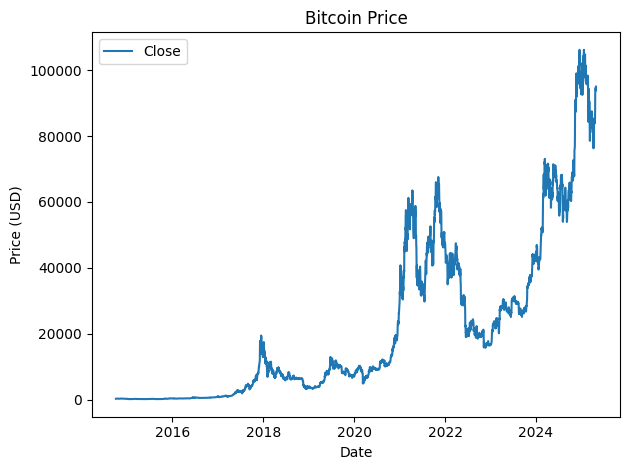

In [4]:
utils.plot_series(
    source_df,
    title="Bitcoin Price",
    y_col="Close",
    x_col="Date",
    xlabel="Date",
    ylabel="Price (USD)",
)

In [5]:
train_df = pd.read_csv(
    config.TRAIN_DATA_PATH,
)

validation_df = pd.read_csv(
    config.VALIDATION_DATA_PATH,
)

test_df = pd.read_csv(
    config.TEST_DATA_PATH,
)

# Calculate the normalization parameters only from the training data
normalize_params = utils.calculate_normalization_params(
    train_df, ["Log_Returns", "Price_SMA_20", "Volume_SMA_20", "Volume"]
)
# Normalize the training, validation, and test data
train_df, validation_df, test_df = utils.normalize_data(
    [train_df, validation_df, test_df], normalize_params
)

2025-05-18 03:42:46,592 - tensorflow_agents_utils - INFO - Column Log_Returns - Mean: 0.0017761469596693997, Std: 0.0391157071475617
2025-05-18 03:42:46,594 - tensorflow_agents_utils - INFO - Column Price_SMA_20 - Mean: 11264.945511346648, Std: 15992.657204566458
2025-05-18 03:42:46,596 - tensorflow_agents_utils - INFO - Column Volume_SMA_20 - Mean: 14729809890.420073, Std: 18544754381.717125
2025-05-18 03:42:46,597 - tensorflow_agents_utils - INFO - Column Volume - Mean: 14806241602.25232, Std: 20044534218.415874
2025-05-18 03:42:46,605 - tensorflow_agents_utils - INFO - Data normalization complete. Data shapes: [(2695, 9), (679, 9), (484, 9)]


In [6]:
train_df = train_df[["Close", "Log_Returns", "Price_SMA_20", "Volume_SMA_20", "Volume"]]
validation_df = validation_df[
    ["Close", "Log_Returns", "Price_SMA_20", "Volume_SMA_20", "Volume"]
]
test_df = test_df[["Close", "Log_Returns", "Price_SMA_20", "Volume_SMA_20", "Volume"]]
utils.save_to_csv(train_df, config.NORM_TRAIN_DATA_PATH)
utils.save_to_csv(validation_df, config.NORM_VALIDATION_DATA_PATH)
utils.save_to_csv(test_df, config.NORM_TEST_DATA_PATH)

2025-05-18 03:42:46,694 - tensorflow_agents_utils - INFO - Data saved to data/train_data_normalized.csv
2025-05-18 03:42:46,704 - tensorflow_agents_utils - INFO - Data saved to data/validation_data_normalized.csv
2025-05-18 03:42:46,717 - tensorflow_agents_utils - INFO - Data saved to data/test_data_normalized.csv


2025-05-18 03:42:46,795 - tensorflow_agents_utils - INFO - Starting DQN Agent Training Script
2025-05-18 03:42:46,797 - tensorflow_agents_utils - INFO - Setting random seed to: 42
2025-05-18 03:42:46,799 - tensorflow_agents_utils - INFO - Creating training and evaluation environments…
2025-05-18 03:42:46,801 - tensorflow_agents_utils - INFO - Attempting to create BitcoinTradingEnv with data from: data/train_data_normalized.csv
2025-05-18 03:42:46,809 - tensorflow_agents_utils - INFO - Successfully loaded data. Shape: (2695, 6), Columns: ['Unnamed: 0', 'Close', 'Log_Returns', 'Price_SMA_20', 'Volume_SMA_20', 'Volume']
2025-05-18 03:42:46,812 - tensorflow_agents_utils - INFO - Using automatically determined feature columns for observation: ['Log_Returns', 'Price_SMA_20', 'Volume_SMA_20', 'Volume']
2025-05-18 03:42:46,815 - tensorflow_agents_utils - INFO - BitcoinTradingEnv (PyEnvironment) created successfully. Observation Spec: BoundedArraySpec(shape=(20, 5), dtype=dtype('float32'), name

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


2025-05-18 03:42:47,891 - tensorflow_agents_utils - INFO - Training dataset created from replay buffer: batch_size=64, num_steps_in_sample=2
2025-05-18 03:42:48,053 - tensorflow_agents_utils - INFO - Starting initial collection of experiences...
2025-05-18 03:42:55,443 - tensorflow_agents_utils - INFO - Initial collection complete. Replay buffer now contains 1000 frames.


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


2025-05-18 03:43:01,362 - tensorflow_agents_utils - INFO - Iter 200 | Step 200 | Loss 0.00004 | Eps 0.972
2025-05-18 03:43:05,414 - tensorflow_agents_utils - INFO - Iter 400 | Step 400 | Loss 0.00003 | Eps 0.943
2025-05-18 03:43:08,434 - tensorflow_agents_utils - INFO - Iter 600 | Step 600 | Loss 0.00002 | Eps 0.915
2025-05-18 03:43:12,765 - tensorflow_agents_utils - INFO - Iter 800 | Step 800 | Loss 0.00002 | Eps 0.887
2025-05-18 03:43:16,908 - tensorflow_agents_utils - INFO - Iter 1000 | Step 1000 | Loss 0.00002 | Eps 0.859
2025-05-18 03:43:41,338 - tensorflow_agents_utils - INFO - Step 1000 | Eval Avg Reward -0.11989 | Directional Acc 0.512


INFO:tensorflow:Assets written to: policy/policy_step_1000_reward_-0.11989.zip/assets


/usr/local/lib/python3.8/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:475: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: policy/policy_step_1000_reward_-0.11989.zip/assets
2025-05-18 03:43:41,882 - tensorflow_agents_utils - INFO - New best policy saved to policy/policy_step_1000_reward_-0.11989.zip
INFO:tensorflow_agents_utils:New best policy saved to policy/policy_step_1000_reward_-0.11989.zip
2025-05-18 03:43:46,288 - tensorflow_agents_utils - INFO - Iter 1200 | Step 1200 | Loss 0.00003 | Eps 0.830
INFO:tensorflow_agents_utils:Iter 1200 | Step 1200 | Loss 0.00003 | Eps 0.830
2025-05-18 03:43:50,750 - tensorflow_agents_utils - INFO - Iter 1400 | Step 1400 | Loss 0.00002 | Eps 0.802
INFO:tensorflow_agents_utils:Iter 1400 | 

INFO:tensorflow:Assets written to: policy/policy_step_2000_reward_0.03821.zip/assets


/usr/local/lib/python3.8/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:475: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: policy/policy_step_2000_reward_0.03821.zip/assets
2025-05-18 03:44:30,721 - tensorflow_agents_utils - INFO - New best policy saved to policy/policy_step_2000_reward_0.03821.zip
INFO:tensorflow_agents_utils:New best policy saved to policy/policy_step_2000_reward_0.03821.zip
2025-05-18 03:44:35,197 - tensorflow_agents_utils - INFO - Iter 2200 | Step 2200 | Loss 0.00002 | Eps 0.689
INFO:tensorflow_agents_utils:Iter 2200 | Step 2200 | Loss 0.00002 | Eps 0.689
2025-05-18 03:44:39,799 - tensorflow_agents_utils - INFO - Iter 2400 | Step 2400 | Loss 0.00002 | Eps 0.661
INFO:tensorflow_agents_utils:Iter 2400 | Ste

INFO:tensorflow:Assets written to: policy/policy_step_10000_reward_0.07710.zip/assets


/usr/local/lib/python3.8/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:475: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: policy/policy_step_10000_reward_0.07710.zip/assets
2025-05-18 03:50:26,652 - tensorflow_agents_utils - INFO - New best policy saved to policy/policy_step_10000_reward_0.07710.zip
INFO:tensorflow_agents_utils:New best policy saved to policy/policy_step_10000_reward_0.07710.zip
2025-05-18 03:50:26,654 - tensorflow_agents_utils - INFO - Training complete.
INFO:tensorflow_agents_utils:Training complete.
2025-05-18 03:50:26,655 - tensorflow_agents_utils - INFO - Displaying training visualizations…
INFO:tensorflow_agents_utils:Displaying training visualizations…


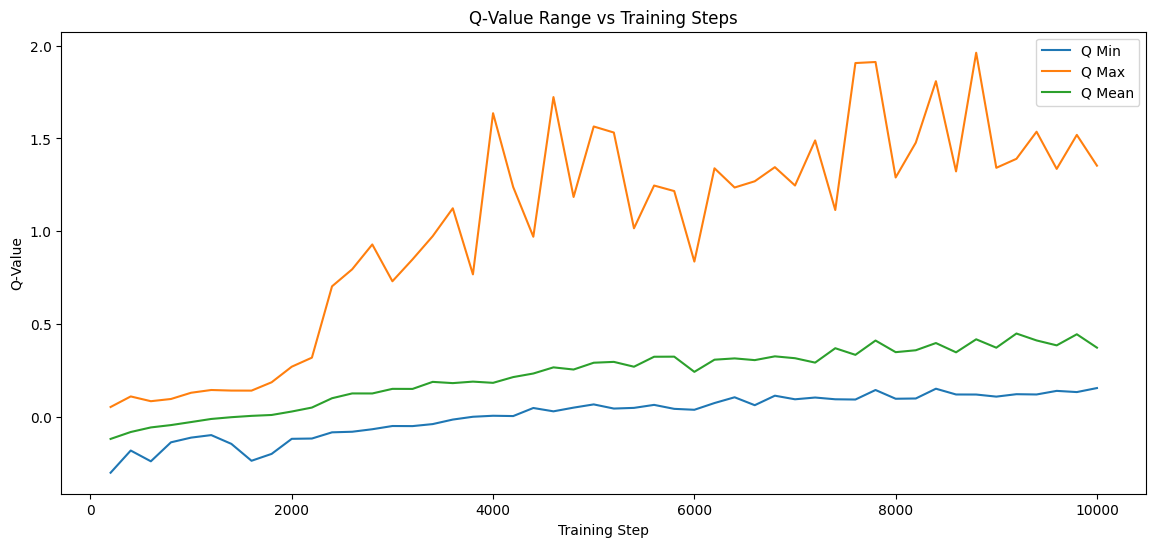

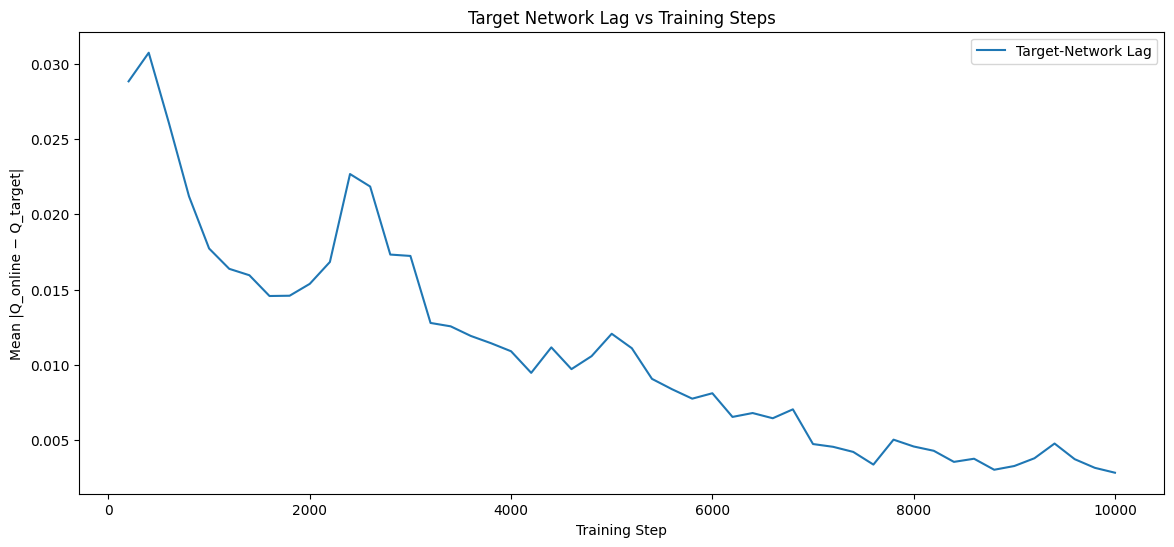

2025-05-18 03:50:27,040 - tensorflow_agents_utils - INFO - Environments closed.
INFO:tensorflow_agents_utils:Environments closed.


In [7]:
# Run train DQN
train_dqn.main(visualize=True)

2025-05-18 03:50:27,058 - tensorflow_agents_utils - INFO - Calculating Buy & Hold performance for data: data/test_data.csv
INFO:tensorflow_agents_utils:Calculating Buy & Hold performance for data: data/test_data.csv
2025-05-18 03:50:27,091 - tensorflow_agents_utils - INFO - Buy & Hold: Buying 0.236517 BTC at 42280.23 on 2024-01-01
INFO:tensorflow_agents_utils:Buy & Hold: Buying 0.236517 BTC at 42280.23 on 2024-01-01
2025-05-18 03:50:27,094 - tensorflow_agents_utils - INFO - Buy & Hold: Holding until 2025-04-28. Last close price: 94978.75. Final value: 22464.10
INFO:tensorflow_agents_utils:Buy & Hold: Holding until 2025-04-28. Last close price: 94978.75. Final value: 22464.10
2025-05-18 03:50:27,097 - tensorflow_agents_utils - INFO - Buy & Hold: Total Return: 124.64%
INFO:tensorflow_agents_utils:Buy & Hold: Total Return: 124.64%


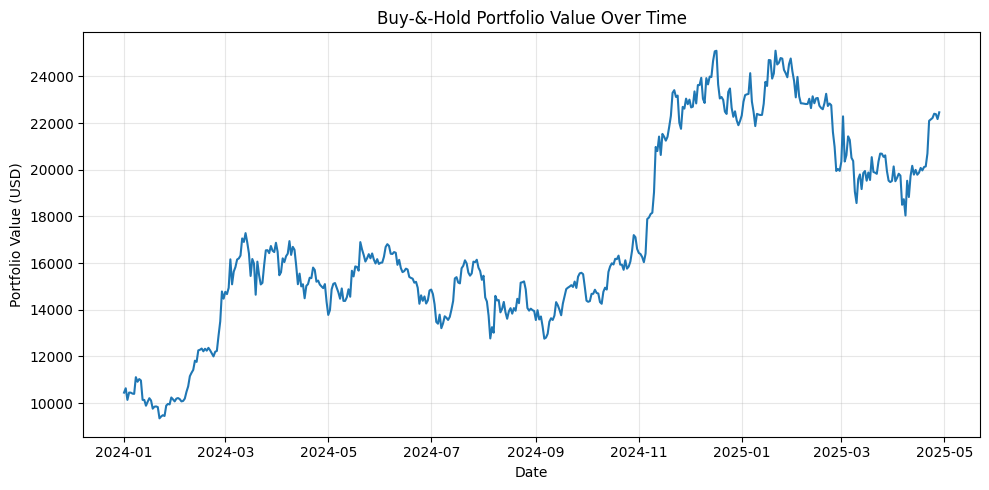

(22464.10205714476,
                     Timestamp  PortfolioValue
 0   2024-01-01 00:00:00+00:00    10446.330936
 1   2024-01-02 00:00:00+00:00    10633.330069
 2   2024-01-03 00:00:00+00:00    10134.327876
 3   2024-01-04 00:00:00+00:00    10449.308649
 4   2024-01-05 00:00:00+00:00    10445.233348
 ..                        ...             ...
 479 2025-04-24 00:00:00+00:00    22219.317907
 480 2025-04-25 00:00:00+00:00    22403.021506
 481 2025-04-26 00:00:00+00:00    22385.620867
 482 2025-04-27 00:00:00+00:00    22174.627255
 483 2025-04-28 00:00:00+00:00    22464.102057
 
 [484 rows x 2 columns],
 124.6410205714476)

In [8]:
utils.calculate_buy_and_hold_performance(
    data_path=config.TEST_DATA_PATH,
    initial_capital=10000,
    visualize=True,
)

2025-05-18 03:50:27,457 - tensorflow_agents_utils - INFO - Calculating Naive 'always_up' accuracy for data: data/test_data.csv
INFO:tensorflow_agents_utils:Calculating Naive 'always_up' accuracy for data: data/test_data.csv
2025-05-18 03:50:27,484 - tensorflow_agents_utils - INFO - Naive 'always_up' Accuracy: 51.55% (249/483 days)
INFO:tensorflow_agents_utils:Naive 'always_up' Accuracy: 51.55% (249/483 days)
2025-05-18 03:50:27,489 - tensorflow_agents_utils - INFO - Calculating Naive 'always_down' accuracy for data: data/test_data.csv
INFO:tensorflow_agents_utils:Calculating Naive 'always_down' accuracy for data: data/test_data.csv
2025-05-18 03:50:27,507 - tensorflow_agents_utils - INFO - Naive 'always_down' Accuracy: 48.45% (234/483 days)
INFO:tensorflow_agents_utils:Naive 'always_down' Accuracy: 48.45% (234/483 days)


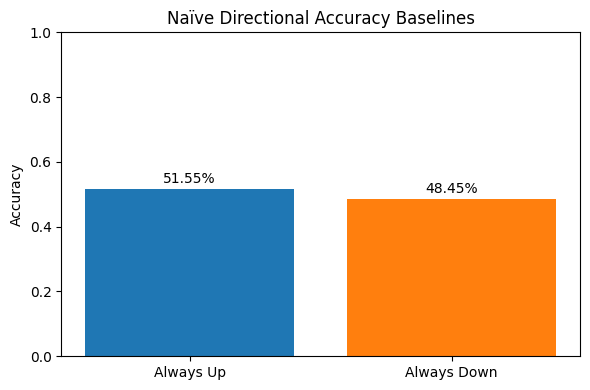

(0.515527950310559, 249, 483)

In [9]:
utils.calculate_naive_directional_accuracy(
    data_path=config.TEST_DATA_PATH,
    prediction_type="always_up",
    visualize=True,
)

In [22]:
best_policy_dir: str = utils.get_best_policy_path(config.POLICY_SAVE_PATH)

2025-05-18 03:52:07,020 - tensorflow_agents_utils - INFO - Best policy found: policy_step_8000_reward_1.02105.zip (reward 1.02105)
INFO:tensorflow_agents_utils:Best policy found: policy_step_8000_reward_1.02105.zip (reward 1.02105)


In [23]:
policy: tf_policy.TFPolicy = tf.saved_model.load(best_policy_dir)

In [24]:
# Set up the test environment (normalised)
test_tf_env: tf_environment.TFEnvironment = utils.create_btc_env(
    data_path=config.NORM_TEST_DATA_PATH,
    window_size=config.WINDOW_SIZE,
    fee=config.FEE,
    feature_columns=None,
    wrap_in_tf_env=True,
)
py_env = test_tf_env.pyenv.envs[0]

2025-05-18 03:52:10,883 - tensorflow_agents_utils - INFO - Attempting to create BitcoinTradingEnv with data from: data/test_data_normalized.csv
INFO:tensorflow_agents_utils:Attempting to create BitcoinTradingEnv with data from: data/test_data_normalized.csv
2025-05-18 03:52:10,893 - tensorflow_agents_utils - INFO - Successfully loaded data. Shape: (484, 6), Columns: ['Unnamed: 0', 'Close', 'Log_Returns', 'Price_SMA_20', 'Volume_SMA_20', 'Volume']
INFO:tensorflow_agents_utils:Successfully loaded data. Shape: (484, 6), Columns: ['Unnamed: 0', 'Close', 'Log_Returns', 'Price_SMA_20', 'Volume_SMA_20', 'Volume']
2025-05-18 03:52:10,896 - tensorflow_agents_utils - INFO - Using automatically determined feature columns for observation: ['Log_Returns', 'Price_SMA_20', 'Volume_SMA_20', 'Volume']
INFO:tensorflow_agents_utils:Using automatically determined feature columns for observation: ['Log_Returns', 'Price_SMA_20', 'Volume_SMA_20', 'Volume']
2025-05-18 03:52:10,901 - tensorflow_agents_utils - 

In [25]:
# Run the policy on the test split
time_step: ts.TimeStep = test_tf_env.reset()
equity_curve: List[float] = [1.0]  # start with $1
prices: List[float] = [float(py_env._df.loc[py_env._current_tick, "Close"])]
rewards: List[float] = []
correct_dir: int = 0
total_trades: int = 0

In [26]:
while not time_step.is_last():
    cur_price: float = float(py_env._df.loc[py_env._current_tick, "Close"])
    action = policy.action(time_step).action
    time_step = test_tf_env.step(action)
    next_price: float = float(py_env._df.loc[py_env._current_tick, "Close"])

    rew: float = float(time_step.reward.numpy()[0])
    rewards.append(rew)
    equity_curve.append(equity_curve[-1] + rew)  # reward in $ terms

    act_val: int = int(action.numpy()[0])
    if act_val in (0, 2):  # short or long
        total_trades += 1
        if (act_val == 2 and next_price > cur_price) or (
            act_val == 0 and next_price < cur_price
        ):
            correct_dir += 1

    prices.append(next_price)

In [27]:
equity_curve_np: np.ndarray = np.array(equity_curve[1:])  # drop initial 1.0
directional_acc_rl: float = correct_dir / total_trades if total_trades else 0.0
total_return_rl: float = (equity_curve_np[-1] - 1.0) * 100.0

In [28]:
# Baseline calculations (Buy & Hold + naive)
bh_value: float
bh_curve: Union[np.ndarray, List]
bh_ret: float
bh_value, bh_curve, bh_ret = utils.calculate_buy_and_hold_performance(
    config.TEST_DATA_PATH, visualize=False
)
bh_curve["NormValue"] = bh_curve["PortfolioValue"] / bh_curve["PortfolioValue"].iloc[0]

naive_up_acc: float
naive_down_acc: float
naive_up_acc, _, _ = utils.calculate_naive_directional_accuracy(
    config.TEST_DATA_PATH, "always_up", visualize=False
)
naive_down_acc, _, _ = utils.calculate_naive_directional_accuracy(
    config.TEST_DATA_PATH, "always_down", visualize=False
)

2025-05-18 03:52:18,664 - tensorflow_agents_utils - INFO - Calculating Buy & Hold performance for data: data/test_data.csv
INFO:tensorflow_agents_utils:Calculating Buy & Hold performance for data: data/test_data.csv
2025-05-18 03:52:18,682 - tensorflow_agents_utils - INFO - Buy & Hold: Buying 0.236517 BTC at 42280.23 on 2024-01-01
INFO:tensorflow_agents_utils:Buy & Hold: Buying 0.236517 BTC at 42280.23 on 2024-01-01
2025-05-18 03:52:18,685 - tensorflow_agents_utils - INFO - Buy & Hold: Holding until 2025-04-28. Last close price: 94978.75. Final value: 22464.10
INFO:tensorflow_agents_utils:Buy & Hold: Holding until 2025-04-28. Last close price: 94978.75. Final value: 22464.10
2025-05-18 03:52:18,688 - tensorflow_agents_utils - INFO - Buy & Hold: Total Return: 124.64%
INFO:tensorflow_agents_utils:Buy & Hold: Total Return: 124.64%
2025-05-18 03:52:18,692 - tensorflow_agents_utils - INFO - Calculating Naive 'always_up' accuracy for data: data/test_data.csv
INFO:tensorflow_agents_utils:Calc

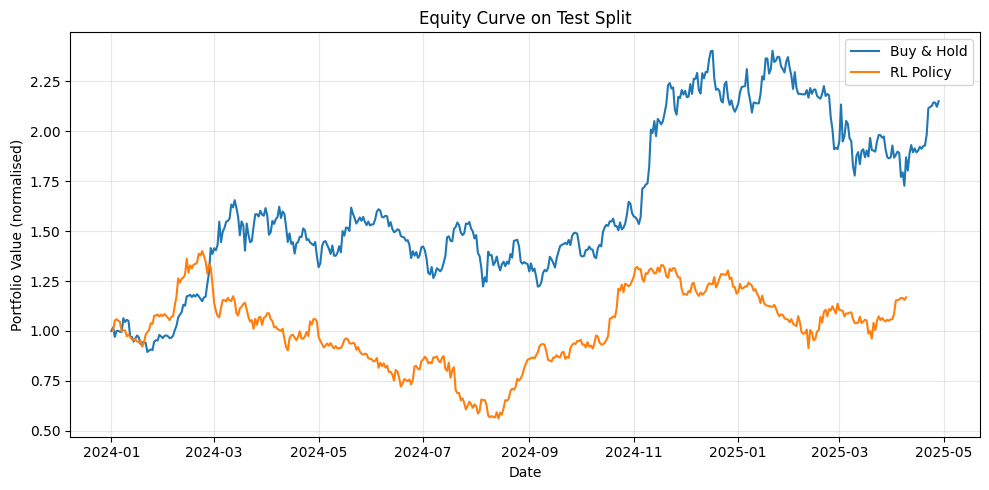

In [29]:
plt.figure(figsize=(10, 5))

rl_len: int = len(equity_curve_np)
dates_rl = bh_curve["Timestamp"].iloc[1 : 1 + rl_len]  # align lengths

plt.plot(bh_curve["Timestamp"], bh_curve["NormValue"], label="Buy & Hold")
plt.plot(dates_rl, equity_curve_np, label="RL Policy")
plt.title("Equity Curve on Test Split")
plt.ylabel("Portfolio Value (normalised)")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

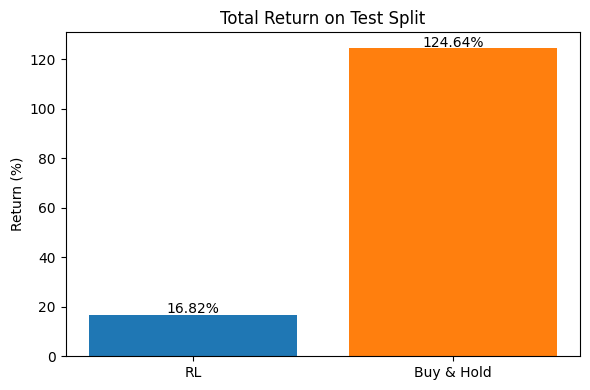

In [30]:
plt.figure(figsize=(6, 4))
plt.bar(
    ["RL", "Buy & Hold"],
    [total_return_rl, bh_ret],
    color=["tab:blue", "tab:orange"],
)
for idx, val in enumerate([total_return_rl, bh_ret]):
    plt.text(idx, val + 0.5, f"{val:.2f}%", ha="center")
plt.title("Total Return on Test Split")
plt.ylabel("Return (%)")
plt.tight_layout()
plt.show()

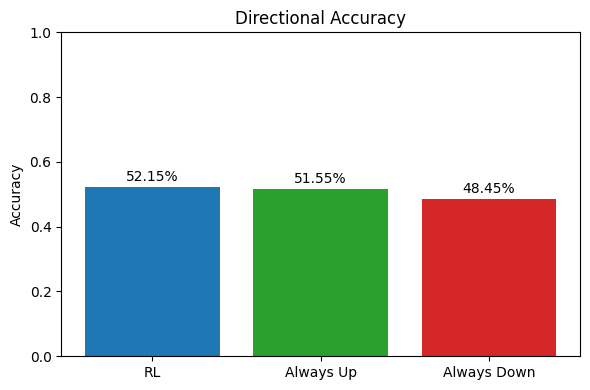

In [31]:
plt.figure(figsize=(6, 4))
plt.bar(
    ["RL", "Always Up", "Always Down"],
    [directional_acc_rl, naive_up_acc, naive_down_acc],
    color=["tab:blue", "tab:green", "tab:red"],
)
for idx, val in enumerate([directional_acc_rl, naive_up_acc, naive_down_acc]):
    plt.text(idx, val + 0.02, f"{val:.2%}", ha="center")
plt.title("Directional Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()